Regression Machine Learning CaseStudy Project Template

 1. Prepare Problem
    a) Load libraries
    b) Load dataset
 2. Summarize Data
  a) Descriptive statistics
  b) Data visualizations
 3. Prepare Data
  a) Data Cleaning
  b) Feature Selection
  c) Data Transforms
 4. Evaluate Algorithms
  a) Split-out validation dataset
  b) Test options and evaluation metric
  c) Spot Check Algorithms
  d) Compare Algorithms
 5. Improve Accuracy
  a) Algorithm Tuning
  b) Ensembles
 6. Finalize Model
  a) Predictions on validation dataset
  b) Create standalone model on entire training dataset
  c) Save model for later use

## 1. Prepare Problem
####  a) Load libraries

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import pandas            as pd
from scipy                         import stats
from numpy                         import set_printoptions
from pandas.plotting               import scatter_matrix
from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler
from sklearn.preprocessing         import MinMaxScaler
from sklearn.preprocessing         import PowerTransformer
from sklearn.model_selection       import KFold
from sklearn.model_selection       import cross_val_score
from sklearn.metrics               import classification_report
from sklearn.metrics               import confusion_matrix
from sklearn.metrics               import accuracy_score
from sklearn.linear_model          import LinearRegression
from sklearn.linear_model          import RANSACRegressor
from sklearn.linear_model          import Lasso
from sklearn.linear_model          import ElasticNet
from sklearn.tree                  import DecisionTreeRegressor
from sklearn.neighbors             import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes           import GaussianNB
from sklearn.svm                   import SVR
from sklearn.feature_selection     import SelectKBest
from sklearn.feature_selection     import chi2
from sklearn.feature_selection     import RFE
from sklearn.decomposition         import PCA
from sklearn.pipeline              import Pipeline
from sklearn.model_selection       import GridSearchCV
from sklearn.ensemble              import RandomForestRegressor
from sklearn.ensemble              import GradientBoostingRegressor
from sklearn.ensemble              import ExtraTreesRegressor
from sklearn.ensemble              import AdaBoostRegressor
from sklearn.metrics               import r2_score
from sklearn.metrics               import mean_squared_error
from sklearn.neighbors             import LocalOutlierFactor # Automatic Outlier Detection
from sklearn.svm                   import OneClassSVM        # Automatic Outlier Detection
from sklearn.covariance            import EllipticEnvelope   # Automatic Outlier Detection
from sklearn.ensemble              import IsolationForest    # Automatic Outlier Detection

In [24]:
def residual_plot(y_train_pred, y_train, y_test_pred, y_test):
    plt.figure(figsize=(20, 10))
    plt.scatter(y_train_pred,  y_train_pred - y_train,c='steelblue', marker='o', 
                edgecolor='white',label='Training data')
    plt.scatter(y_test_pred,  y_test_pred - y_test,c='limegreen', marker='s', 
                edgecolor='white',label='Test data')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
    plt.xlim([-10, 50])
    plt.show()
    print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                           r2_score(y_test, y_test_pred)))

In [3]:
# Automatic Outlier Detection
def Automatic_Outlier_Removal(X,Y,param, method='IsolationForest'):
    if method == 'IsolationForest':
        """
        IsolationForest is a tree-based anomaly detection algorithm
        
        # Perhaps the most important hyperparameter in the model is the
        # “contamination” argument, which is used to help estimate 
        # the number of outliers in the dataset. 
        # This is a value between 0.0 and 0.5 and by default is set to 0.1.
        """
        AOR = IsolationForest(contamination=param)

    elif method == 'EllipticEnvelope':
        """
        'Robust covariance method'
        An object for detecting outliers in a 'Gaussian distributed' dataset.
        
        It provides the “contamination” argument that defines the expected ratio of outliers 
        to be observed in practice. In this case, we will set it to a value of 0.01, 
        found with a little trial and error.
        """
        AOR = EllipticEnvelope(contamination=param)

    elif method == 'LocalOutlierFactor':
        """
        Is a technique that attempts to harness the idea of nearest neighbors for outlier detection
        
        A simple approach to identifying outliers is to locate those examples that 
        are far from the other examples in the feature space.

        This can work well for feature spaces with low dimensionality (few features), 
        although it can become less reliable as the number of features is increased, 
        referred to as the curse of dimensionality.
        """
        AOR = LocalOutlierFactor()
        
    elif method == 'OneClassSVM':
        """
        When modeling one classSVM, the algorithm captures the density of the majority class 
        and classifies examples on the extremes of the density function as outliers. 
        This modification of SVM is referred to as One-Class SVM.
        
        “nu” argument that specifies the approximate ratio of outliers in the dataset,
        which defaults to 0.1. In this case, 
        we will set it to 0.01, found with a little trial and error.
        """
        
        AOR = OneClassSVM(nu=param)
    
    yhat = AOR.fit_predict(X)
        
    # select all rows that are not outliers
    mask = yhat != -1
    X, Y = X[mask, :], Y[mask]
    return X, Y
    
    


####  a) Load dataset

In [4]:
data_ind = 1 # 1:Housing 2:iris

if data_ind == 1:
    """
    The attributes are defined as follows (Housing dataset):
        1.CRIM: per capita crime rate by town
        2.ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
        3.INDUS: proportion of non-retail business acres per town
        4.CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        5.NOX: nitric oxides concentration (parts per 10 million)
        6.RM: average number of rooms per dwelling
        7.AGE: proportion of owner-occupied units built prior to 1940
        8.DIS: weighted distances to five Boston employment centers
        9.RAD: index of accessibility to radial highways
        10.TAX: full-value property-tax rate per$10,000
        11.PTRATIO: pupil-teacher ratio by town
        12.B: 1000(Bk−0.63)2where Bk is the proportion of blacks by town
        13.LSTAT: % lower status of the population
        14.MEDV: Median value of owner-occupied homes in$1000s
    """
    data_name    = 'housing'
    data_url     = 'data/housing/housing.data.txt'
    data_header  =  ['CRIM','ZN','INDUS','CHAS','NOX',
                     'RM','AGE','DIS','RAD','TAX',
                     'PTRATIO','B','LSTAT','MEDV']
    cols         = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
    X_sample     ='LSTAT'
    Y_sample     ='MEDV'
    reorder_col  = 0
    num_folds    = 10
    seed         = 7
    scoring      ='neg_mean_squared_error'
    stratify     = True
    test_size    = 0.3
    Feature_Sel  = False
    sep_         = '\s+'
    
    outlier_handling = True
    pred_var = 'MEDV'
    OL_cut = 50
    column_sels_hi_corr = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
    data_prep_explor = False
    
    """
    0. 'ZN' (proportion of residential land zoned for lots over 25,000 sq.ft.) 
             with 0 for 25th, 50th percentiles. 
       Second, 'CHAS': Charles River dummy variable (1 if tract bounds river; 0 otherwise) 
       with 0 for 25th, 50th and 75th percentiles. 
       These summeries are understandable as both variables are conditional + categorical variables. 
       First assumption would be that these coulms may not be useful in regression task such as 
       predicting MEDV (Median value of owner-occupied homes)
    1.Columns like  CRIM, ZN, RM, B  seems to have outliers. Let's see the outliers percentage in every column.
    2. remove MEDV outliers (MEDV = 50.0). From the original data description, it says: 
        Variable #14 seems to be censored at 50.00 (corresponding to a median price of $50,000). 
        Based on that, values above 50.00 may not help to predict MEDV. 
    3. The histogram also shows that columns 'CRIM', 'ZN', 'B' has highly skewed distributions. 
        Also 'MEDV' looks to have a normal distribution (the predictions) and other colums seem to 
        have normal or bimodal ditribution of data except CHAS (which is a discrete variable).
    4. From correlation matrix, we see TAX and RAD are highly correlated features. 
        The columns LSTAT, INDUS, RM, TAX, NOX, PTRAIO has a correlation score above '0.5' with MEDV 
        which is a good indication of using as predictors.
    5. So with these analsis, we may try predict MEDV with 'LSTAT', 'INDUS', 'NOX', 'PTRATIO', 
        'RM', 'TAX', 'DIS', 'AGE' features. 
        Let's try to remove the skewness of the data trough log transformation.
    
    """
    
elif data_ind == 2:
    """
    Dataset 2
    """
    data_name    = ''
    data_url     = 'data/housing/...'
    data_header  =  []
    cols        = []
    X_sample           =''
    Y_sample           =''
    reorder_col = 0
    num_folds = 10
    seed      = 7
    scoring   ='neg_mean_squared_error'
    stratify    = False
    test_size   = 0.3
    Feature_Sel = False
    sep_ = ','
    
    
df =  pd.read_csv(data_url,header=None,sep=sep_)
df.columns = data_header

# 'class' or y --> end column
if reorder_col == 1:
    df = df[oreder]


## 2. Summarize the Dataset
    a) Descriptive statistics
    b) Data Visualization
    

###        2.a   Descriptive statistics
    1. Dimensions of the dataset. 
    2. Peek at the data itself.
    3. Statistical summary of all attributes
    4. Breakdown of the data by the class variable.

In [5]:
print(df.shape)

(506, 14)


In [6]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [7]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### 2.b Data Visualization
    1.  Univariate Plots
    2.  Multivariate Plots

"\n# Density\n\nplt.rcParams['figure.figsize'] = (20.0, 10.0)\ndf.plot(kind='density', subplots=True, layout=(7,2), sharex=False, legend=True,fontsize=1)\nplt.show()\n\n# skip the na values \n# find skewness in each column \ndf[column_sels_hi_corr].skew(axis = 0, skipna = True) \n"

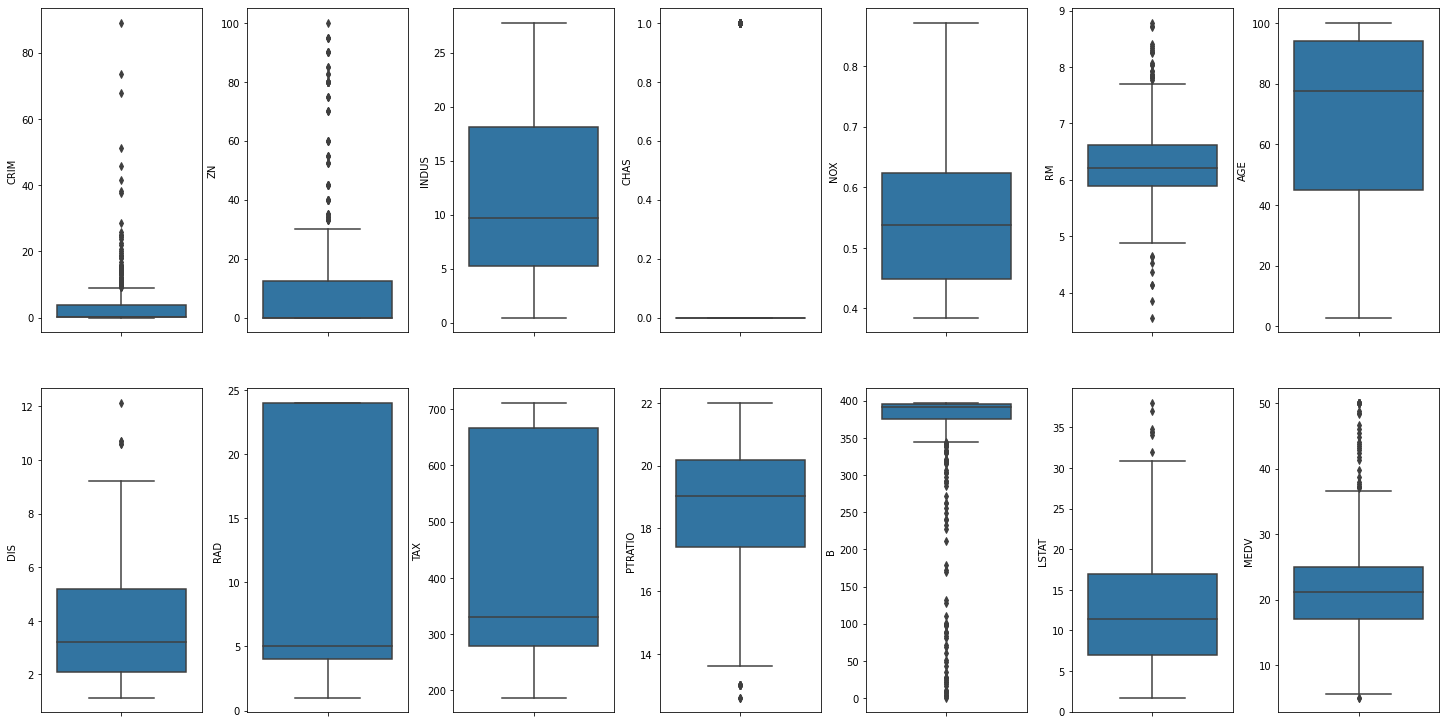

In [8]:
# box and whisker plots
"""
plt.rcParams['figure.figsize'] = (20.0, 10.0)
df.plot(kind='box', subplots=True,layout=(5,int(df.shape[1]/5)+1), sharex=False, sharey=False)
plt.show()
"""
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

"""
# Density

plt.rcParams['figure.figsize'] = (20.0, 10.0)
df.plot(kind='density', subplots=True, layout=(7,2), sharex=False, legend=True,fontsize=1)
plt.show()

# skip the na values 
# find skewness in each column 
df[column_sels_hi_corr].skew(axis = 0, skipna = True) 
"""

###  Let's see the outliers percentage in every column.

In [9]:
if outlier_handling:
    for k, v in df.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        IQR = q3 - q1
        v_col = v[(v <= q1 - 1.5 * IQR) | (v >= q3 + 1.5 * IQR)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
        print("Column %s outliers = %.2f %%" % (k, perc))
    
    
    # Let's remove pred_var outliers (pred_var = OL_cut)
    df = df[~(df[pred_var] >= OL_cut)]
    print(df.shape)
    
    
    

Column CRIM outliers = 13.04 %
Column ZN outliers = 13.44 %
Column INDUS outliers = 0.00 %
Column CHAS outliers = 100.00 %
Column NOX outliers = 0.00 %
Column RM outliers = 5.93 %
Column AGE outliers = 0.00 %
Column DIS outliers = 0.99 %
Column RAD outliers = 0.00 %
Column TAX outliers = 0.00 %
Column PTRATIO outliers = 2.96 %
Column B outliers = 15.22 %
Column LSTAT outliers = 1.38 %
Column MEDV outliers = 7.91 %
(490, 14)


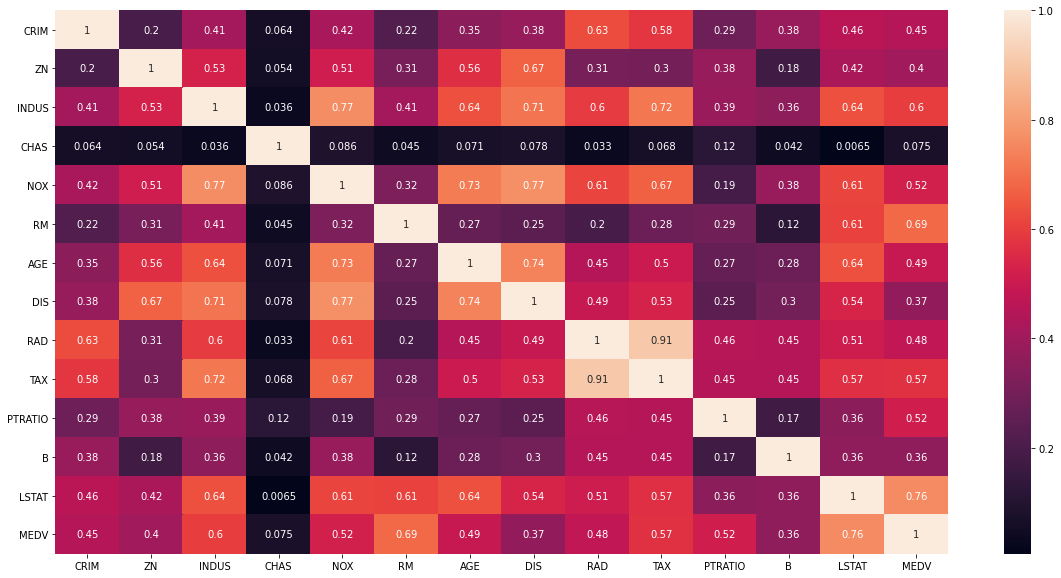

In [10]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr().abs(),  annot=True)
plt.show()

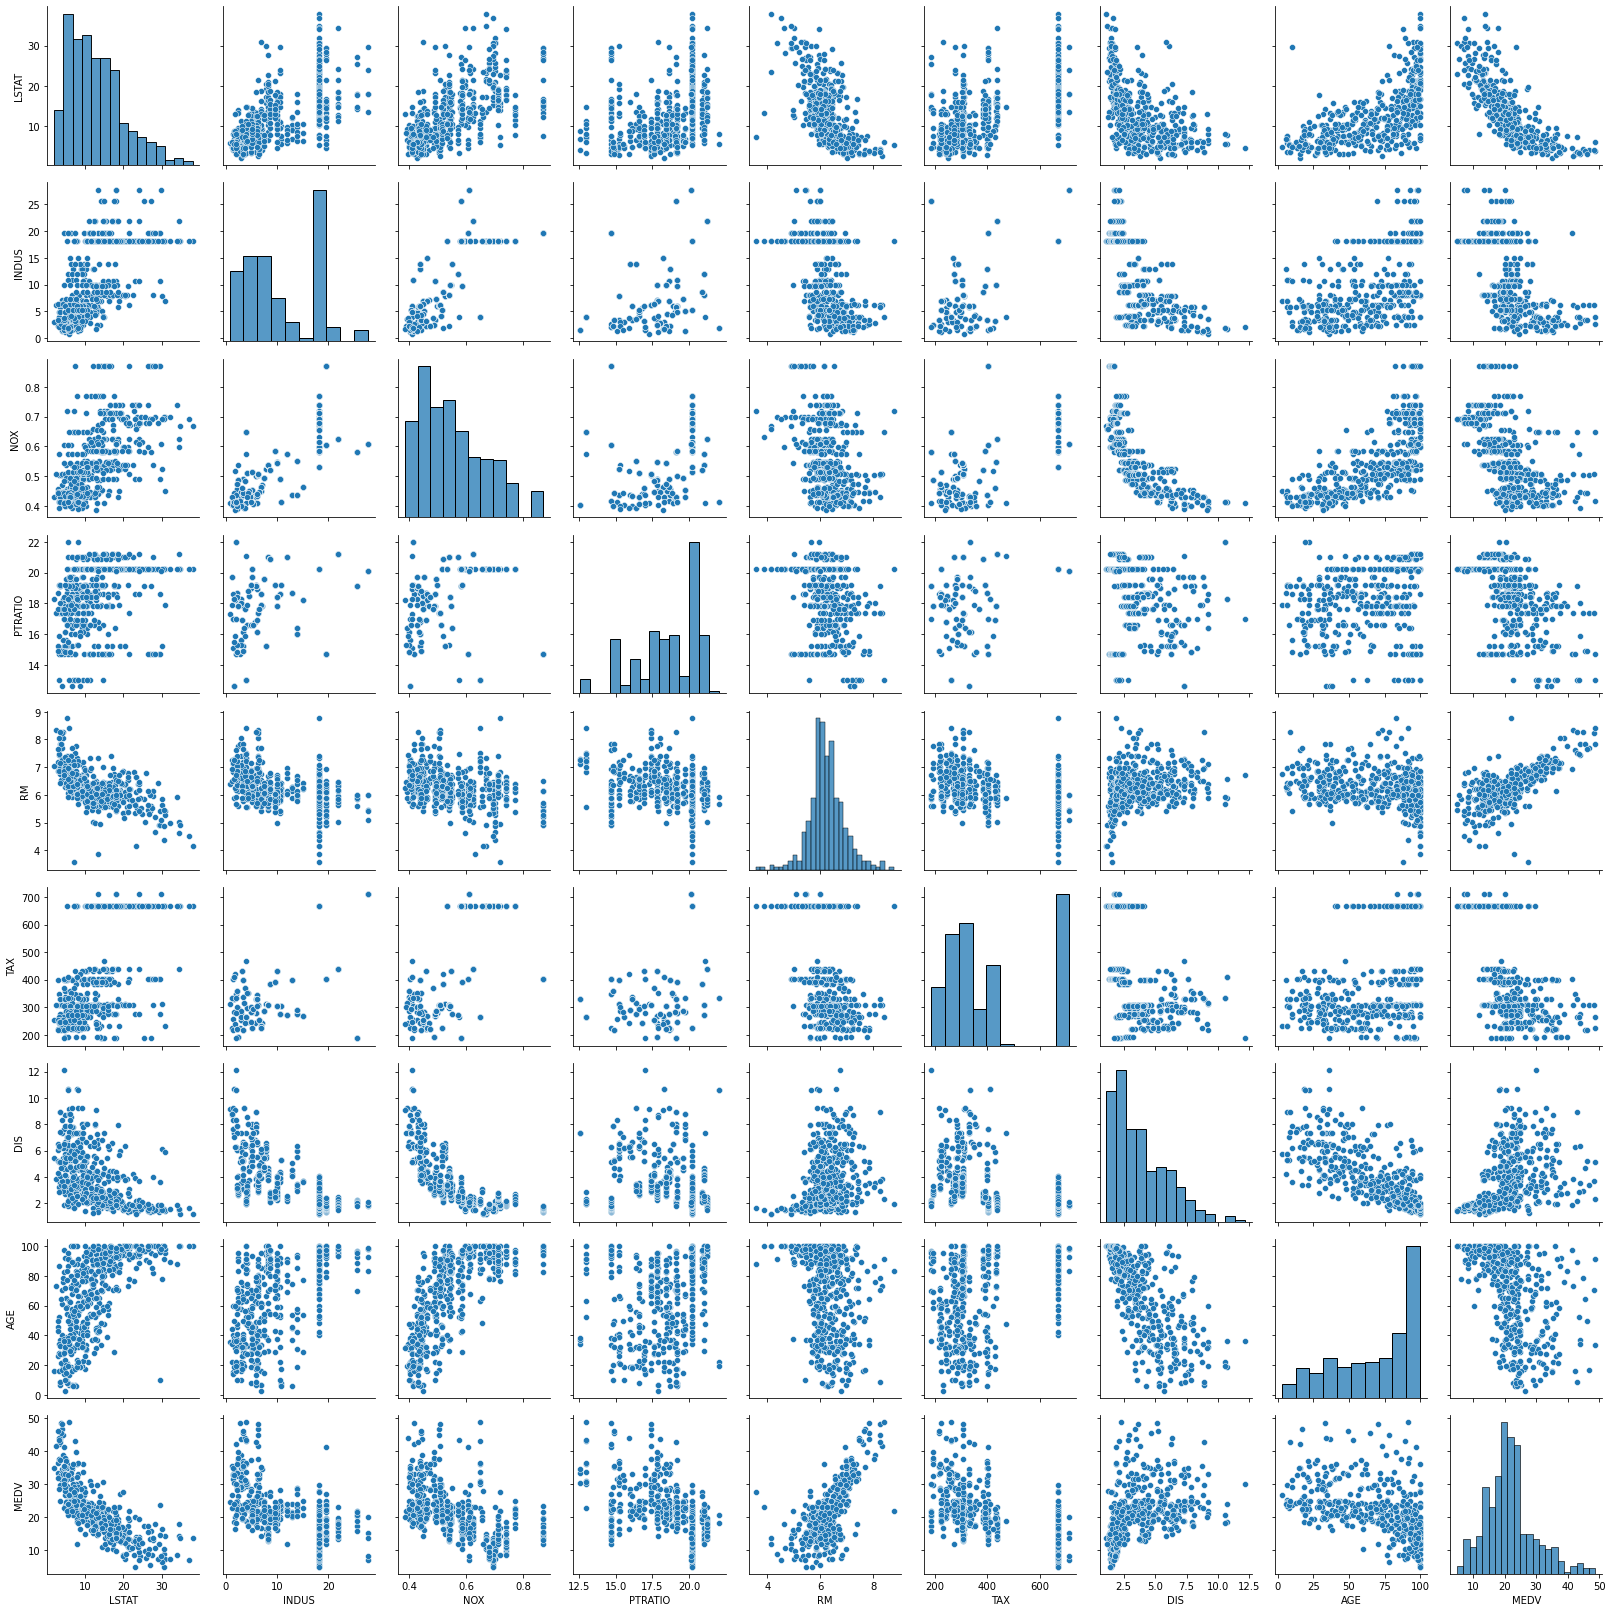

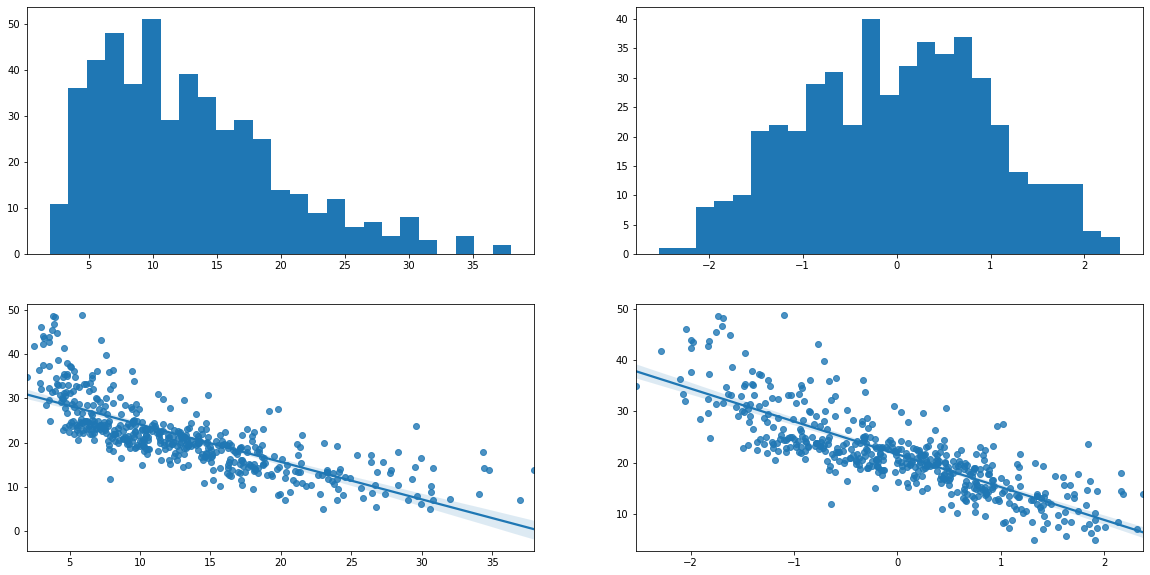

In [21]:
# scatter plot matrix + histograms
#scatter_matrix(df, figsize=(12, 8))

sns.pairplot(df[column_sels_hi_corr+['MEDV']], height=2.5)
plt.tight_layout()
plt.show()
"""
Below are some common values for lambda

    lambda = -1. is a reciprocal transform.
    lambda = -0.5 is a reciprocal square root transform.
    lambda = 0.0 is a log transform.
    lambda = 0.5 is a square root transform.
    lambda = 1.0 is no transform.

"""
#  zoom in


x = df[X_sample].values
y = df[Y_sample].values


# reshape data to have rows and columns

x = x.reshape((len(x),1))
power = PowerTransformer()
x_transformed =  power.fit_transform(x)
"""
x_transformed =  np.log(x)
"""
plt.figure(1,figsize=(20, 10))
plt.subplot(2,2,1)
plt.hist(x, bins=25)

plt.subplot(2,2,2)
plt.hist(x_transformed, bins=25)

plt.subplot(2,2,3)
sns.regplot(y=y, x=x)

#plt.show()
#df[X_sample] = pd.DataFrame(np.squeeze(x_transformed)) 
 
plt.subplot(2,2,4)
sns.regplot(y=y, x=x_transformed)

plt.show()




## 3.  Prepare Data
    a) Data Cleaning
    b) Feature Selection
    c) Data Transforms

In [12]:
# Let's scale the columns before plotting them against MEDV
# Let's try to remove the skewness of the data trough Box-Cox transformation
if data_prep_explor:

    scaler = MinMaxScaler(feature_range=(1, 2))
    power = PowerTransformer(method='box-cox')
    pipeline = Pipeline(steps=[('s', scaler),('p', power)])


    min_max_scaler = MinMaxScaler()

    x = df.loc[:,column_sels_hi_corr].values
    y = df[pred_var]
    x = pipeline.fit_transform(x)
    x = pd.DataFrame(x, columns=column_sels_hi_corr)

    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
    axs = axs.flatten()

    # Plot the relationship between two variables in a DataFrame
    for i, k in enumerate(column_sels_hi_corr):
        sns.regplot(y=y, x=x[k], ax=axs[i])
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

## 4. Evaluate Algorithms
    a) Split-out validation dataset
    b) Test options and evaluation metric
    c) Spot Check Algorithms
    d) Compare Algorithms

In [13]:
X = df.loc[:,column_sels_hi_corr].values
Y = df[pred_var]
X_train, X_test, y_train, y_test = train_test_split(X, Y,
        test_size=test_size, random_state=seed)
print(X_train.shape, y_train.shape)
X_train,y_train = Automatic_Outlier_Removal(X_train,y_train,0.1, method='IsolationForest')
print(X_train.shape, y_train.shape)

(343, 8) (343,)
(308, 8) (308,)


 ###  4.2 Make Predictions

In [14]:
# Standardize the dataset
# Test options and evaluation metric

pipelines = []

pipelines.append(('ScaledLR'   , Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('Scaledransac'   , Pipeline([('Scaler', StandardScaler()),('ransac',RANSACRegressor(LinearRegression(),max_trials=100,  min_samples=50, 
                loss='absolute_loss', residual_threshold=5.0, random_state=0))])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledEN'   , Pipeline([('Scaler', StandardScaler()),('EN',ElasticNet())])))
pipelines.append(('ScaledKNN'  , Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsRegressor())])))
pipelines.append(('ScaledCART' , Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR'  , Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
names = []


for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

"""
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
"""

ScaledLR: -12.969004 (2.908490)
Scaledransac: -13.907795 (3.319576)
ScaledLASSO: -15.814187 (4.612232)
ScaledEN: -16.630588 (5.213105)
ScaledKNN: -11.181142 (3.311947)
ScaledCART: -15.786341 (5.167963)
ScaledSVR: -13.728440 (3.991109)


"\n# Compare Algorithms\nfig = plt.figure()\nfig.suptitle('Scaled Algorithm Comparison')\nax = fig.add_subplot(111)\nplt.boxplot(results)\nax.set_xticklabels(names)\nplt.show()\n"

In [15]:
# KNN Algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = np.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print("Best: %f using %s \n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -11.215461 using {'n_neighbors': 3} 

-16.294323 (5.855011) with: {'n_neighbors': 1}
-11.215461 (3.606357) with: {'n_neighbors': 3}
-11.215725 (3.395135) with: {'n_neighbors': 5}
-11.548956 (4.241176) with: {'n_neighbors': 7}
-11.911389 (3.973789) with: {'n_neighbors': 9}
-12.048083 (4.233073) with: {'n_neighbors': 11}
-12.140769 (4.750497) with: {'n_neighbors': 13}
-12.515782 (5.239311) with: {'n_neighbors': 15}
-12.588474 (5.424541) with: {'n_neighbors': 17}
-12.887965 (5.391369) with: {'n_neighbors': 19}
-13.128267 (5.599119) with: {'n_neighbors': 21}


ScaledLR: -13.122290 (2.885641)
Scaledransac: -13.663424 (2.952718)
ScaledLASSO: -15.378375 (4.318001)
ScaledEN: -16.479767 (4.922202)
ScaledKNN: -11.459512 (4.079808)
ScaledCART: -17.111772 (5.596916)
ScaledSVR: -13.332516 (3.977070)


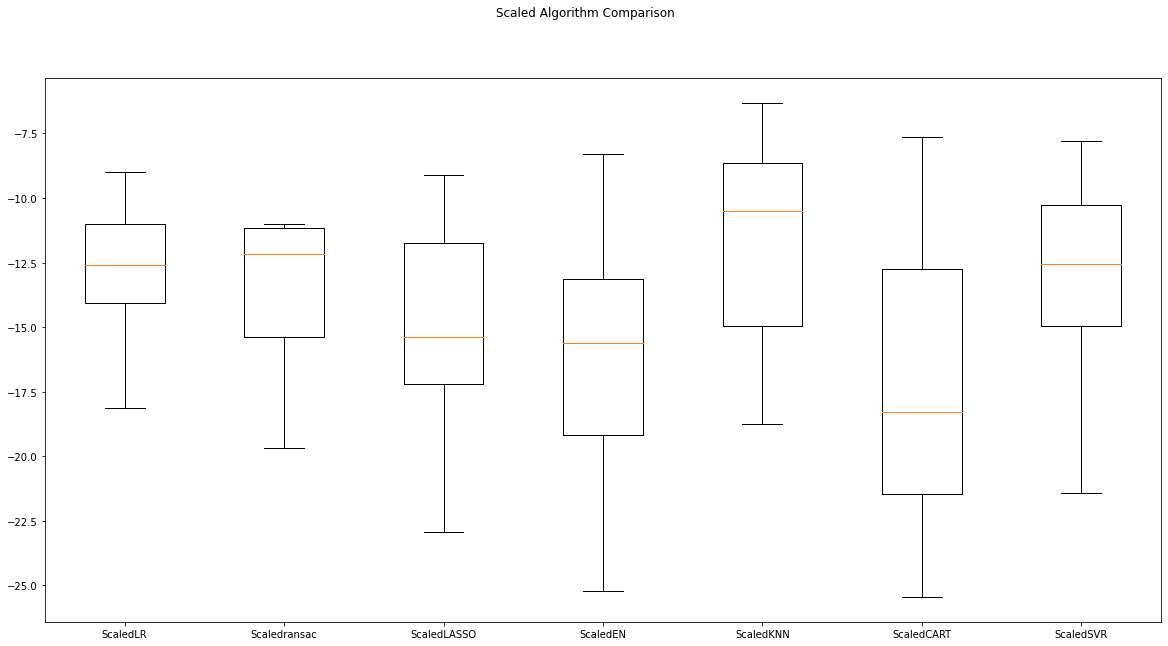

In [22]:
# Standardize the dataset
# Test options and evaluation metric
num_folds = 10
seed      = 7
scoring   ='neg_mean_squared_error'
pipelines = []
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
pipelines.append(('ScaledLR'   , Pipeline([('s', scaler),('p', power),('LR',LinearRegression())])))
pipelines.append(('Scaledransac'   , Pipeline([('s', scaler),('p', power),('ransac',RANSACRegressor(LinearRegression(),max_trials=100,  min_samples=50, 
                loss='absolute_loss', residual_threshold=5.0, random_state=0))])))
pipelines.append(('ScaledLASSO', Pipeline([('s', scaler),('p', power),('LASSO',Lasso())])))
pipelines.append(('ScaledEN'   , Pipeline([('s', scaler),('p', power),('EN',ElasticNet())])))
pipelines.append(('ScaledKNN'  , Pipeline([('s', scaler),('p', power),('KNN',KNeighborsRegressor())])))
pipelines.append(('ScaledCART' , Pipeline([('s', scaler),('p', power),('CART',DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR'  , Pipeline([('s', scaler),('p', power),('SVR', SVR())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


###  Tuning SVM

In [17]:
# Tune scaled SVM

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear','poly','rbf','sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVR()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print("Best: %f using %s \n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -11.322728 using {'C': 2.0, 'kernel': 'rbf'} 

-13.479642 (3.557835) with: {'C': 0.1, 'kernel': 'linear'}
-24.371082 (8.979599) with: {'C': 0.1, 'kernel': 'poly'}
-37.042393 (13.104121) with: {'C': 0.1, 'kernel': 'rbf'}
-28.717388 (10.657272) with: {'C': 0.1, 'kernel': 'sigmoid'}
-12.837787 (3.165856) with: {'C': 0.3, 'kernel': 'linear'}
-19.190689 (7.771264) with: {'C': 0.3, 'kernel': 'poly'}
-25.180867 (9.191218) with: {'C': 0.3, 'kernel': 'rbf'}
-21.605569 (7.543331) with: {'C': 0.3, 'kernel': 'sigmoid'}
-12.827826 (3.162380) with: {'C': 0.5, 'kernel': 'linear'}
-17.263206 (7.494960) with: {'C': 0.5, 'kernel': 'poly'}
-18.993969 (6.553253) with: {'C': 0.5, 'kernel': 'rbf'}
-21.497158 (7.076022) with: {'C': 0.5, 'kernel': 'sigmoid'}
-12.768278 (3.085785) with: {'C': 0.7, 'kernel': 'linear'}
-16.350477 (6.883211) with: {'C': 0.7, 'kernel': 'poly'}
-15.888844 (4.963312) with: {'C': 0.7, 'kernel': 'rbf'}
-26.437432 (8.177206) with: {'C': 0.7, 'kernel': 'sigmoid'}
-12.750005 (3.084

### Ensemble Methods

ScaledAB: -11.300773 (4.255565)
ScaledGBM: -9.838399 (4.293082)
ScaledRF: -9.709954 (3.487267)
ScaledET: -8.695527 (3.354065)


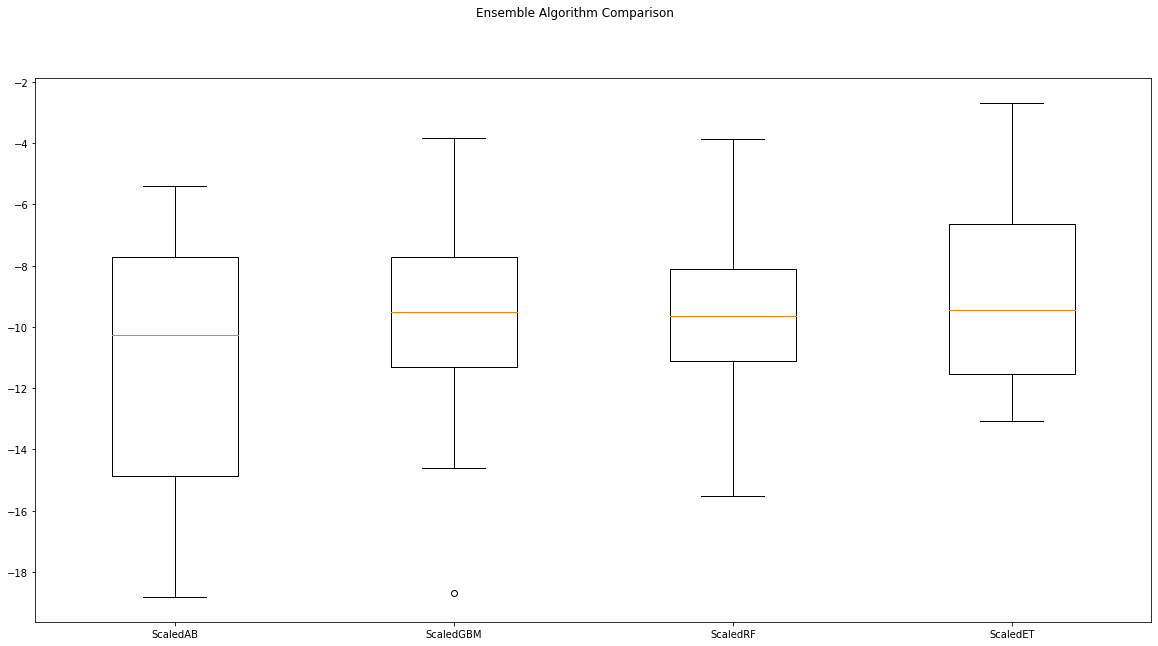

In [23]:
# ensembles

ensembles = []
ensembles.append(('ScaledAB',  Pipeline([('Scaler', StandardScaler()),('AB',AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM',GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET',ExtraTreesRegressor())])))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# Compare Algorithms
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

###  Finalize Model

In [19]:
# Tune scaled GBM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
model = ExtraTreesRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print("Best: %f using %s \n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -8.537251 using {'n_estimators': 300} 

-8.868776 (3.170217) with: {'n_estimators': 50}
-8.639105 (3.246420) with: {'n_estimators': 100}
-8.591125 (3.216700) with: {'n_estimators': 150}
-8.630123 (3.262384) with: {'n_estimators': 200}
-8.554259 (3.209805) with: {'n_estimators': 250}
-8.537251 (3.195843) with: {'n_estimators': 300}
-8.553751 (3.225140) with: {'n_estimators': 350}
-8.538941 (3.229640) with: {'n_estimators': 400}


2.8860028860268577e-07
6.22313069236582


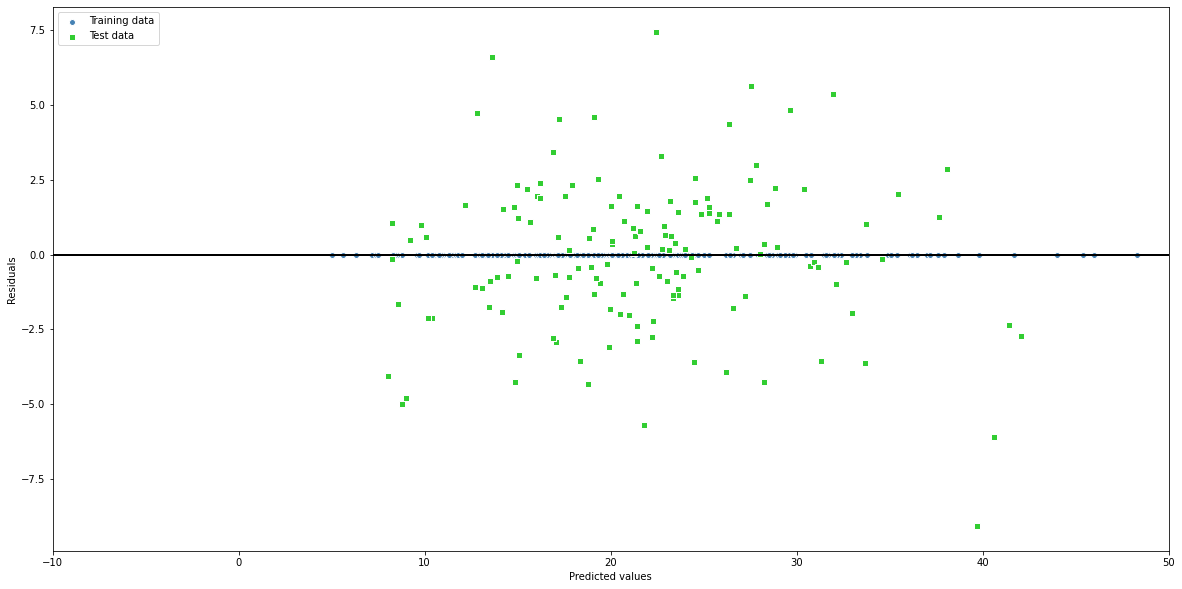

R^2 train: 1.000, test: 0.894


In [25]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = ExtraTreesRegressor(random_state=seed, n_estimators=grid_result.best_params_['n_estimators'])
model.fit(rescaledX, y_train)
y_train_pred = model.predict(rescaledX)
print(mean_squared_error(y_train, y_train_pred))

# transform the validation dataset
rescaledTestX = scaler.transform(X_test)
y_test_pred = model.predict(rescaledTestX)
print(mean_squared_error(y_test, y_test_pred))
residual_plot(y_train_pred, y_train, y_test_pred, y_test)